In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

hgrid = xr.open_dataset("/glade/u/home/manishrv/documents/nwa12_0.1/mom_input/n3b.clean/hgrid.nc")
print(hgrid)

<xarray.Dataset> Size: 111MB
Dimensions:   (nyp: 1561, nxp: 1481, ny: 1560, nx: 1480)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    tile      |S255 255B ...
    y         (nyp, nxp) float64 18MB ...
    x         (nyp, nxp) float64 18MB ...
    dy        (ny, nxp) float64 18MB ...
    dx        (nyp, nx) float64 18MB ...
    area      (ny, nx) float64 18MB ...
    angle_dx  (nyp, nxp) float64 18MB ...
Attributes:
    file_name:    ocean_hgrid.nc
    Description:  MOM6 NCAR NWA12
    Author:       Fred Castruccio (fredc@ucar.edu)
    Created:      2024-04-18T08:39:49.607481
    type:         MOM6 supergrid file


In [4]:
k = 2
kp2 = k //2
tlon = hgrid.x[kp2::k,kp2::k]
tlat = hgrid.y[kp2::k,kp2::k]

# U point locations
ulon = hgrid.x[kp2::k,::k]
ulat = hgrid.y[kp2::k,::k]

# V point locations
vlon = hgrid.x[::k,kp2::k]
vlat = hgrid.y[::k,kp2::k]

# Corner point locations
qlon = hgrid.x[::k,::k]
qlat = hgrid.y[::k,::k]


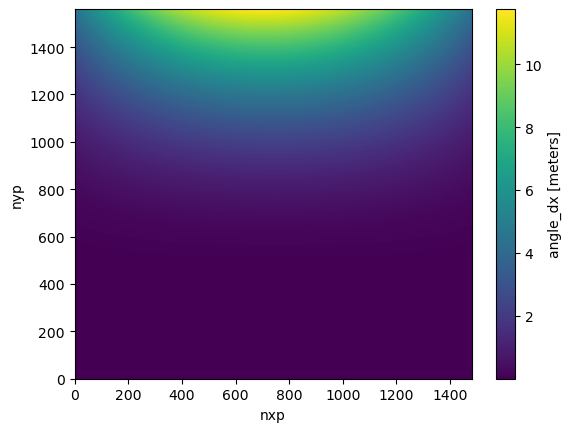

In [5]:
hgrid["angle_dx"].plot()

    pi_720deg = atan(1.0) / 180.0
    len_lon = 360.0 ; if (G%len_lon > 0.0) len_lon = G%len_lon
    do j=G%jsc,G%jec ; do i=G%isc,G%iec
      do n=1,2 ; do m=1,2
        lonB(m,n) = modulo_around_point(G%geoLonBu(I+m-2,J+n-2), G%geoLonT(i,j), len_lon)
      enddo ; enddo
      lon_scale = cos(pi_720deg*((G%geoLatBu(I-1,J-1) + G%geoLatBu(I,J)) + &
                                 (G%geoLatBu(I,J-1) + G%geoLatBu(I-1,J)) ) )
      angle = atan2(lon_scale*((lonB(1,2) - lonB(2,1)) + (lonB(2,2) - lonB(1,1))), &
                    (G%geoLatBu(I-1,J) - G%geoLatBu(I,J-1)) + &
                    (G%geoLatBu(I,J) - G%geoLatBu(I-1,J-1)) )
      G%sin_rot(i,j) = sin(angle) ! angle is the clockwise angle from lat/lon to ocean
      G%cos_rot(i,j) = cos(angle) ! grid (e.g. angle of ocean "north" from true north)

    function modulo_around_point(x, xc, Lx) result(x_mod)
      real, intent(in) :: x  !< Value to which to apply modulo arithmetic [A]
      real, intent(in) :: xc !< Center of modulo range [A]
      real, intent(in) :: Lx !< Modulo range width [A]
      real :: x_mod          !< x shifted by an integer multiple of Lx to be close to xc [A].

      if (Lx > 0.0) then
        x_mod = modulo(x - (xc - 0.5*Lx), Lx) + (xc - 0.5*Lx)
      else
        x_mod = x
      endif
    end function modulo_around_point

In [6]:
# Direct Translation
pi_720deg = np.arctan(1)/180 # One quarter the conversion factor from degrees to radians
 
## Check length of longitude
len_lon = 360.0
G_len_lon = hgrid.x.max() - hgrid.x.min()
if G_len_lon != 360:
    print("This is a regional case")
    len_lon = G_len_lon



This is a regional case


In [7]:
## Iterate it, j=G%jsc,G%jec ; do i=G%isc,G%iec mean we iterate from jsc to jec and isc to iec
## Then you iterate around it, 1,2 and 1,2

# In this way we wrap each longitude in the correct way even if we are at the seam like 360, I still don't understand it as much


def modulo_around_point(x, xc, Lx):
    """
    This function calculates the modulo around a point, for use in cases where we are wrapping around the globe at the seam. Return the modulo value of x in an interval [xc-(Lx/2) xc+(Lx/2)]. If Lx<=0, then it returns x without applying modulo arithmetic.
    Parameters
    ----------
    x: float
        Value to which to apply modulo arithmetic
    xc: float
        Center of modulo range
    Lx: float
        Modulo range width
    Returns
    -------
    float
        x shifted by an integer multiple of Lx to be close to xc, 
    """
    if Lx <= 0:
        return x
    else:
        return ((x - (xc - 0.5*Lx)) % Lx )- Lx/2 + xc



In [13]:
angles_arr_v2 = np.zeros((len(tlon.nyp), len(tlon.nxp)))

# Compute lonB for all points
lonB = np.zeros((2, 2, len(tlon.nyp), len(tlon.nxp)))

# Vectorized computation of lonB
for n in np.arange(1,3):
    for m in np.arange(1,3):
        lonB[m-1, n-1] = modulo_around_point(qlon[np.arange((m-2+1),(m-2+len(qlon.nyp))), np.arange((n-2+1),(n-2+len(qlon.nxp)))], tlon, len_lon)

# Compute lon_scale
lon_scale = np.cos(pi_720deg* ((qlat[0:-1, 0:-1] + qlat[1:, 1:]) + (qlat[1:, 0:-1] + qlat[0:-1, 1:])))



# Compute angle
angle = np.arctan2(
    lon_scale * ((lonB[0, 1] - lonB[1, 0]) + (lonB[1, 1] - lonB[0, 0])),
    (qlat[:-1, :-1] - qlat[1:, 1:]) + (qlat[1:, 0:-1] - qlat[0:-1, 1:])
)
# Assign angle to angles_arr
angles_arr_v2 =  np.rad2deg(angle) - 90
# Print the result
print(angles_arr_v2)

<xarray.DataArray 'y' (nyp: 780, nxp: 740)> Size: 5MB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [4.43651643, 4.47489525, 4.5132071 , ..., 4.40963338, 4.37648025,
        4.34327766],
       [4.45746382, 4.49601954, 4.53450787, ..., 4.429975  , 4.39669398,
        4.36336333],
       [4.47848207, 4.51721524, 4.5558806 , ..., 4.45038282, 4.41697365,
        4.38351466]])
Dimensions without coordinates: nyp, nxp


In [12]:
np.rad2deg(angle)

<xarray.DataArray 'y' (nyp: 780, nxp: 740)> Size: 5MB
array([[90.        , 90.        , 90.        , ..., 90.        ,
        90.        , 90.        ],
       [90.        , 90.        , 90.        , ..., 90.        ,
        90.        , 90.        ],
       [90.        , 90.        , 90.        , ..., 90.        ,
        90.        , 90.        ],
       ...,
       [94.43651643, 94.47489525, 94.5132071 , ..., 94.40963338,
        94.37648025, 94.34327766],
       [94.45746382, 94.49601954, 94.53450787, ..., 94.429975  ,
        94.39669398, 94.36336333],
       [94.47848207, 94.51721524, 94.5558806 , ..., 94.45038282,
        94.41697365, 94.38351466]])
Dimensions without coordinates: nyp, nxp

In [22]:
# Create the new DataArray with the new dimensions
new_data_array = xr.DataArray(
    angles_arr_v2,
    dims=["qy", "qx"],
    coords={
        "qy": tlon.nyp.values,
        "qx": tlon.nxp.values,
    }
)



hgrid["angle_dx_mom6"] = new_data_array
hgrid["angle_dx_mom6"].attrs["_FillValue"] = np.nan
hgrid["angle_dx_mom6"].attrs["units"] = "rad"
hgrid["angle_dx_mom6"].attrs["description"] = "MOM6 calculates angles internally, this field replicates that for rotating boundary conditions. Use this over other angle fields for MOM6 applications"


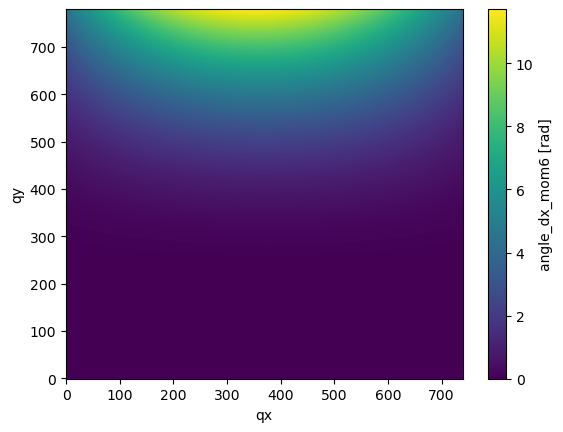

In [ ]:
hgrid["angle_dx_mom6"].plot(vmin = 0)

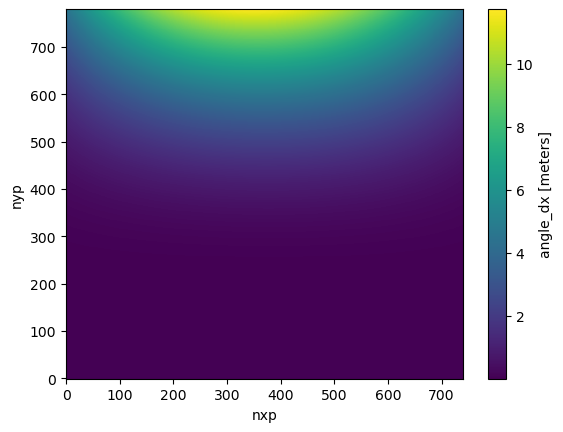

In [26]:
hgrid["angle_dx"][kp2::k,kp2::k].plot()

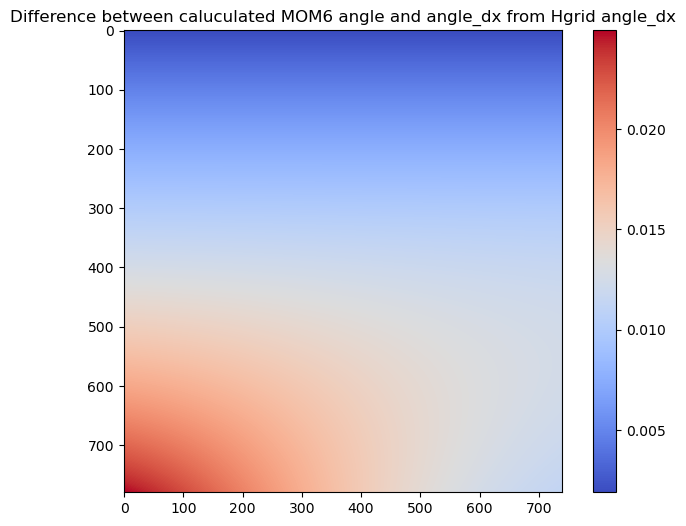

In [31]:
angle_diff = hgrid["angle_dx"][kp2::k,kp2::k].values - hgrid["angle_dx_mom6"].values
plt.figure(figsize=(8, 6))
plt.imshow(angle_diff,cmap='coolwarm')
plt.colorbar()
plt.title("Difference between caluculated MOM6 angle and angle_dx from Hgrid angle_dx")
plt.show()

In [13]:
hgrid

<xarray.Dataset> Size: 129MB
Dimensions:        (nyp: 1561, nxp: 1481, ny: 1560, nx: 1480)
Dimensions without coordinates: nyp, nxp, ny, nx
Data variables:
    tile           |S255 255B ...
    y              (nyp, nxp) float64 18MB ...
    x              (nyp, nxp) float64 18MB -98.0 -97.96 -97.92 ... -37.49 -37.45
    dy             (ny, nxp) float64 18MB ...
    dx             (nyp, nx) float64 18MB ...
    area           (ny, nx) float64 18MB ...
    angle_dx       (nyp, nxp) float64 18MB ...
    angle_dx_mom6  (nyp, nxp) float64 18MB 0.0 0.0 0.0 0.0 ... 4.414 4.397 4.38
Attributes:
    file_name:    ocean_hgrid.nc
    Description:  MOM6 NCAR NWA12
    Author:       Fred Castruccio (fredc@ucar.edu)
    Created:      2024-04-18T08:39:49.607481
    type:         MOM6 supergrid file